# YT 2020: INDEXER Testing

Перепроверить расчеты можно тут https://yt.yandex-team.ru/hahn/resource-planner/ 

In [1]:
# обязательный импорт для каждого питонячего ноутбука
PATH_REGEXP = r'(preorder/v\d+apr)'
DEFAULT_KEY = None#'ent_test'
import os
import re
import sys
import logging
from pathlib import Path
cwd = os.getcwd()
preorder_key = max(re.findall(PATH_REGEXP, cwd))
capacity_path = Path(cwd[:cwd.rfind(preorder_key)])
sys.path.extend([str(capacity_path), str(capacity_path / preorder_key), str(capacity_path / ("../" * 4))])
import market.sre.tools.capacity.lib.tools as tools

Deprecated self-made module, try to use https://yt.yandex-team.ru/docs/description/chyt/cli_and_api


In [2]:
# paramaters add tag here
forecast_start_date = "2020-07-01"
forecast_end_date = "2020-08-01"
history_start_date = "2020-04-01"
history_end_date = "2020-05-01"
dau_white = 5500000
dau_blue = 4000000
offers_white = 2000000
offers_blue = 0
orders_blue = 0
dc_minus_one = True
gencfg_dir = '2020-05'
service_file_name='indexer'
department='INDEXER'
service_key_words = ['indexer']
preorder_id='aug20'
out_dir='out/yt'
revision_number='current'
kpi_key=None

In [3]:
# Parameters
src_file_name = "indexer_testing"
service_file_name = "indexer_testing"
service_key_words = ["production"]
department = "INDEXER"
forecast_start_date = "2021-02-01"
forecast_end_date = "2022-06-01"
history_start_date = "2019-01-01"
history_end_date = "2021-01-01"
dau_white = 8700000
dau_blue = 42
offers_white = 1300000000
offers_blue = 42
orders_blue = "248974"
kpi_key = "dw_8700000_db_42_ofw_1300000000_ofb_42_orb_248974"
dc_minus_one = "True"
out_dir = "out/preorder/yt"
gencfg_dir = "v2021_02/"
previous_kpi_key = "dw_8700000_db_42_ofw_1300000000_ofb_42_orb_248974"
revision_number = "dw_8700000_db_42_ofw_1300000000_ofb_42_orb_248974/2022-06-01"
df_dir = "out/preorder/yt/dw_8700000_db_42_ofw_1300000000_ofb_42_orb_248974/2022-06-01/dataframes"


In [4]:
import pandas as pd
import numpy as np
from pprint import pformat
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

%matplotlib inline

import warnings
warnings.simplefilter("ignore", UserWarning)

In [5]:
from market.sre.tools.capacity.lib.YT.Cluster import Cluster
from market.sre.tools.capacity.preorder.v2020apr.preorder_lib.core.predictor import Formula, Feature, FormulaStrategy, Predictor, Window
from market.sre.tools.capacity.preorder.v2020apr.input_data.YT_accounts import arnold_accounts, hahn_accounts, seneca_sas_accounts, seneca_man_accounts, seneca_vla_accounts
from market.sre.tools.capacity.preorder.v2020apr.input_data.YT_pools import hahn_pools_list, hahn_pools_dict, arnold_pools_list, arnold_pools_dict
from market.sre.tools.capacity.preorder.v2020apr.additional.YT.disk_forecaster import get_disk_forecast
from market.sre.tools.capacity.preorder.v2020apr.additional.YT.cpu_forecaster import get_cpu_forecast
from market.sre.tools.capacity.preorder.v2020apr.preorder_lib.yt.yt_order import YTOrderRequestFile, YTOrderRequestFileItem, YtOrderRequestFileItemDiskQuota, YtOrderRequestFileItemCpuQuota, YtOrderRequestFileItemDTQuota
from market.sre.tools.capacity.preorder.v2020apr.preorder_lib.core.types.department import Department
from market.sre.tools.capacity.preorder.v2020apr.preorder_lib.core.department_info import DepartmentInfo
from market.sre.tools.capacity.preorder.v2020apr.preorder_lib.core.types.cloud import Cloud
from market.sre.tools.capacity.preorder.v2020apr.preorder_lib.core.types.reason import Reason
from market.sre.tools.capacity.preorder.v2020apr.preorder_lib.core.types.deadline import Deadline
from market.sre.tools.capacity.preorder.v2020apr.preorder_lib.core.types.platform import Platform
from market.sre.tools.capacity.preorder.v2020apr.preorder_lib.core.resources_info import ResourcesInfo
from market.sre.tools.capacity.preorder.v2020apr.additional.YT.tools import clean_YT_account

## Настройки

In [6]:
# откуда смотреть историю потребления
date_start = history_start_date
date_end =history_end_date
forecast_date = forecast_end_date
result_dir = out_dir
start_key=kpi_key
tools.set_start_key(start_key)
target_dir = capacity_path / preorder_key / f"additional/RTC/src/{out_dir}/{revision_number}/dataframes"

# verbose
verbose = True

# учитывать ли пики в пуле?
consider_peaks = False

# grid
grid = True

tail_depth = 7
quantile = .8

# formula
formula = None

# formula stratery
formula_strategy = FormulaStrategy.FIRST

# настройки Predictor'а
decreasing_base_function = 'mean'
decreasing_reserve = 1
features = [Feature.OFFERS_COUNT]

# defaults
default_platform = Platform.INFRA
default_department = Department.INDEXER

notebook_filename = f"https://a.yandex-team.ru/arc/trunk/arcadia/market/sre/tools/capacity/{preorder_key}/additional/FORECAST/YT/indexer_testing.ipynb"
notebook_filename

'https://a.yandex-team.ru/arc/trunk/arcadia/market/sre/tools/capacity/preorder/v2020apr/additional/FORECAST/YT/indexer_testing.ipynb'

In [7]:
whois = ResourcesInfo(capacity_path / preorder_key / "input_data/files/whois", default_platform=default_platform, default_department=default_department)

In [8]:
plt.rcParams['figure.figsize'] = (15, 5)
plt.rcParams['grid.color'] = 'k'
plt.rcParams['grid.linestyle'] = ':'
plt.rcParams['grid.linewidth'] = 0.5
plt.rcParams['figure.dpi'] = 80
plt.rcParams['savefig.dpi'] = 100

grid = True

In [9]:
predictor = Predictor()

### ENV

In [10]:
# тестинг это все кроме прода
env = 'production'

## Disk

#### Accounts

In [11]:
label = 'indexer'

_hahn_accounts = [account for account in hahn_accounts if label in account and account not in [account for account in hahn_accounts if label in account and env in account]]
_arnold_accounts = [account for account in arnold_accounts if label in account and account not in [account for account in arnold_accounts if label in account and env in account]]
_seneca_sas_accounts = [account for account in seneca_sas_accounts if label in account and account not in [account for account in seneca_sas_accounts if label in account and env in account]]
_seneca_man_accounts = [account for account in seneca_man_accounts if label in account and account not in [account for account in seneca_man_accounts if label in account and env in account]]
_seneca_vla_accounts = [account for account in seneca_vla_accounts if label in account and account not in [account for account in seneca_vla_accounts if label in account and env in account]]

cluster_accounts = {
    Cluster.HAHN: _hahn_accounts,
    Cluster.ARNOLD: _arnold_accounts,
    Cluster.SENECA_SAS: _seneca_sas_accounts,
    Cluster.SENECA_MAN: _seneca_man_accounts,
    Cluster.SENECA_VLA: _seneca_vla_accounts,
    
}

print(cluster_accounts)

{<Cluster.HAHN: 'hahn'>: ['market-indexer-development', 'market-indexer-testing'], <Cluster.ARNOLD: 'arnold'>: ['market-indexer-development', 'market-indexer-testing', 'market-red-indexer-testing'], <Cluster.SENECA_SAS: 'seneca-sas'>: ['market-indexer-testing'], <Cluster.SENECA_MAN: 'seneca-man'>: [], <Cluster.SENECA_VLA: 'seneca-vla'>: ['market-indexer-testing']}


HAHN DEFAULT usage: 21921 / 10240 Gb = 214.07 %


/Users/strkate/.conda/envs/capacity/lib/python3.8/site-packages/pandas/core/frame.py:1485: FutureWarning: Using short name for 'orient' is deprecated. Only the options: ('dict', list, 'series', 'split', 'records', 'index') will be used in a future version. Use one of the above to silence this warning.
  warnings.warn(


/Users/strkate/.conda/envs/capacity/lib/python3.8/site-packages/pandas/core/frame.py:1485: FutureWarning: Using short name for 'orient' is deprecated. Only the options: ('dict', list, 'series', 'split', 'records', 'index') will be used in a future version. Use one of the above to silence this warning.
  warnings.warn(


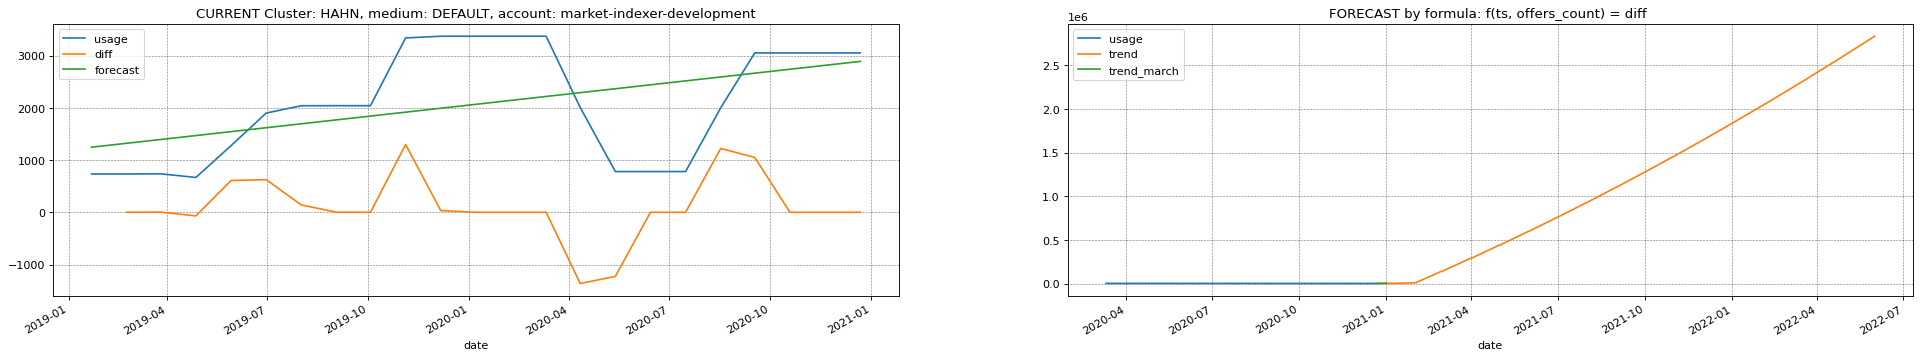

Correlations: {<Formula.F_TS_OFFERS_eq_DIFF: 'f(ts, offers_count) = diff'>: 0.6581465796629917,
 <Formula.F_TS_OFFERS_eq_VALUE: 'f(ts, offers_count) = value'>: -0.555395263860571}


/Users/strkate/.conda/envs/capacity/lib/python3.8/site-packages/pandas/core/frame.py:1485: FutureWarning: Using short name for 'orient' is deprecated. Only the options: ('dict', list, 'series', 'split', 'records', 'index') will be used in a future version. Use one of the above to silence this warning.
  warnings.warn(
/Users/strkate/.conda/envs/capacity/lib/python3.8/site-packages/pandas/core/frame.py:1485: FutureWarning: Using short name for 'orient' is deprecated. Only the options: ('dict', list, 'series', 'split', 'records', 'index') will be used in a future version. Use one of the above to silence this warning.
  warnings.warn(


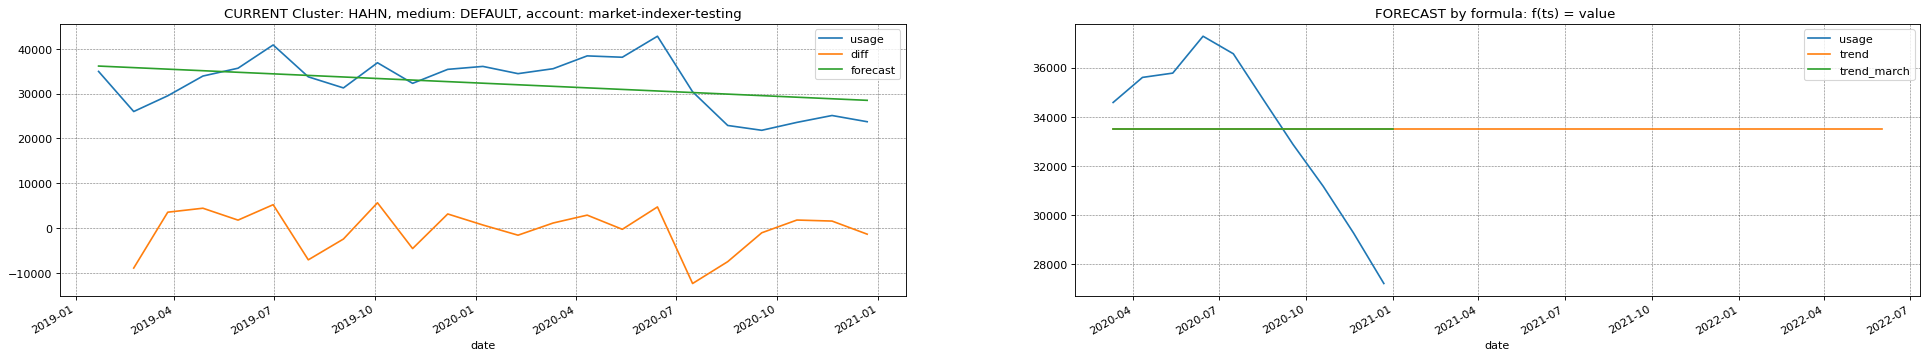

Correlations: {<Formula.F_TS_OFFERS_eq_DIFF: 'f(ts, offers_count) = diff'>: -0.7252735597627143,
 <Formula.F_TS_OFFERS_eq_VALUE: 'f(ts, offers_count) = value'>: -0.8705045937653021}


HAHN SSD usage: 270 / 9718 Gb = 2.78 %


/Users/strkate/.conda/envs/capacity/lib/python3.8/site-packages/pandas/core/frame.py:1485: FutureWarning: Using short name for 'orient' is deprecated. Only the options: ('dict', list, 'series', 'split', 'records', 'index') will be used in a future version. Use one of the above to silence this warning.
  warnings.warn(
/Users/strkate/.conda/envs/capacity/lib/python3.8/site-packages/pandas/core/frame.py:1485: FutureWarning: Using short name for 'orient' is deprecated. Only the options: ('dict', list, 'series', 'split', 'records', 'index') will be used in a future version. Use one of the above to silence this warning.
  warnings.warn(


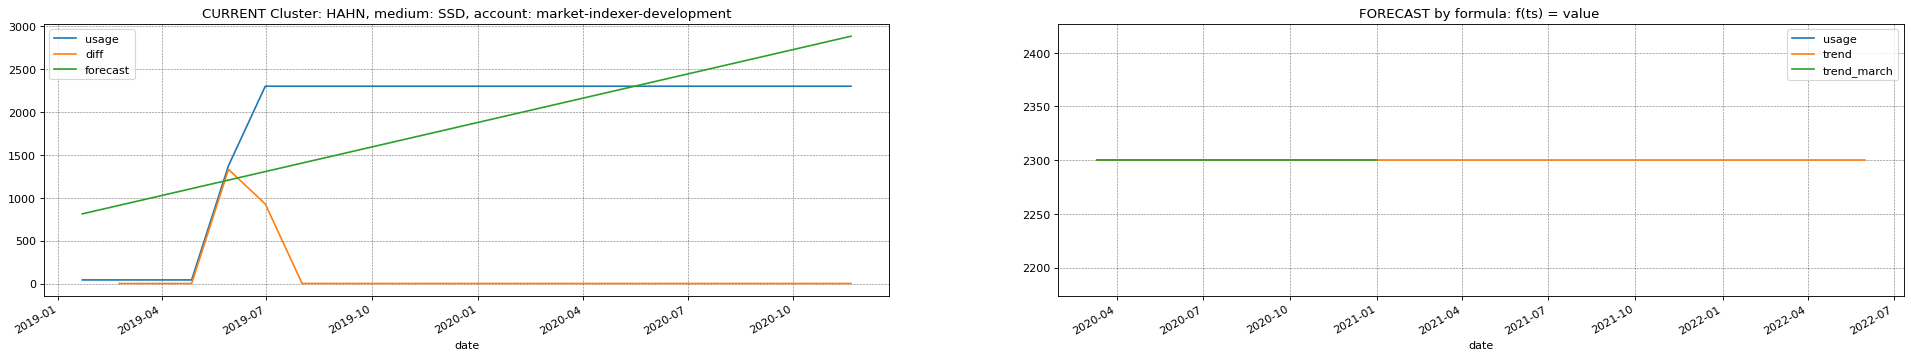

Correlations: {<Formula.F_TS_OFFERS_eq_DIFF: 'f(ts, offers_count) = diff'>: nan,
 <Formula.F_TS_OFFERS_eq_VALUE: 'f(ts, offers_count) = value'>: nan}


/Users/strkate/.conda/envs/capacity/lib/python3.8/site-packages/pandas/core/frame.py:1485: FutureWarning: Using short name for 'orient' is deprecated. Only the options: ('dict', list, 'series', 'split', 'records', 'index') will be used in a future version. Use one of the above to silence this warning.
  warnings.warn(
/Users/strkate/.conda/envs/capacity/lib/python3.8/site-packages/pandas/core/frame.py:1485: FutureWarning: Using short name for 'orient' is deprecated. Only the options: ('dict', list, 'series', 'split', 'records', 'index') will be used in a future version. Use one of the above to silence this warning.
  warnings.warn(


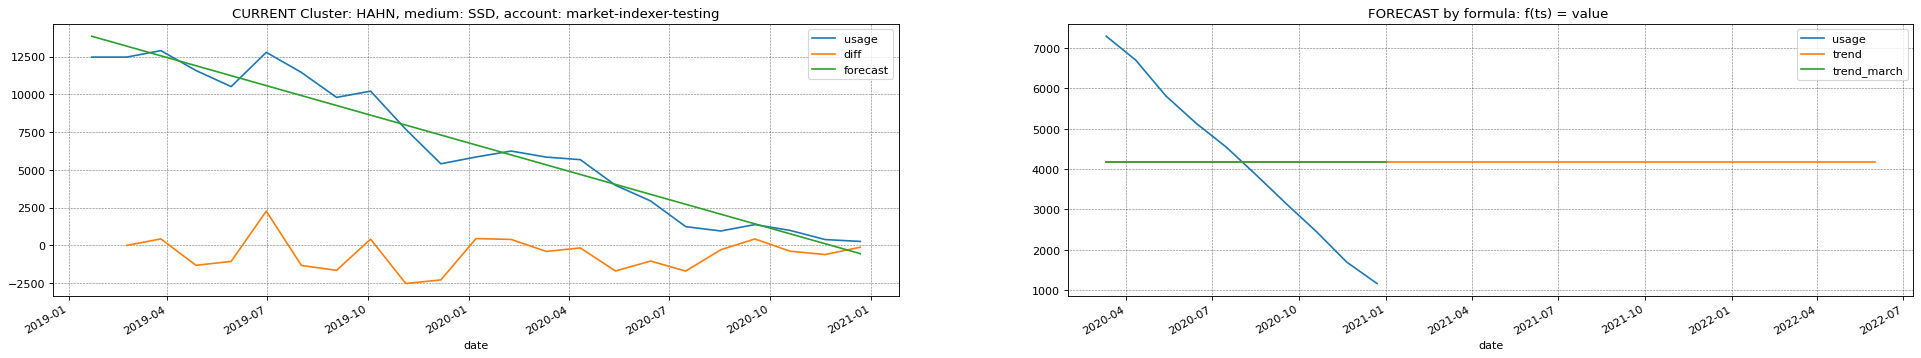

Correlations: {<Formula.F_TS_OFFERS_eq_DIFF: 'f(ts, offers_count) = diff'>: 0.2835669397298484,
 <Formula.F_TS_OFFERS_eq_VALUE: 'f(ts, offers_count) = value'>: -0.9404410146930788}


ARNOLD DEFAULT usage: 64518 / 10240 Gb = 630.06 %


/Users/strkate/.conda/envs/capacity/lib/python3.8/site-packages/pandas/core/frame.py:1485: FutureWarning: Using short name for 'orient' is deprecated. Only the options: ('dict', list, 'series', 'split', 'records', 'index') will be used in a future version. Use one of the above to silence this warning.
  warnings.warn(
/Users/strkate/.conda/envs/capacity/lib/python3.8/site-packages/pandas/core/frame.py:1485: FutureWarning: Using short name for 'orient' is deprecated. Only the options: ('dict', list, 'series', 'split', 'records', 'index') will be used in a future version. Use one of the above to silence this warning.
  warnings.warn(


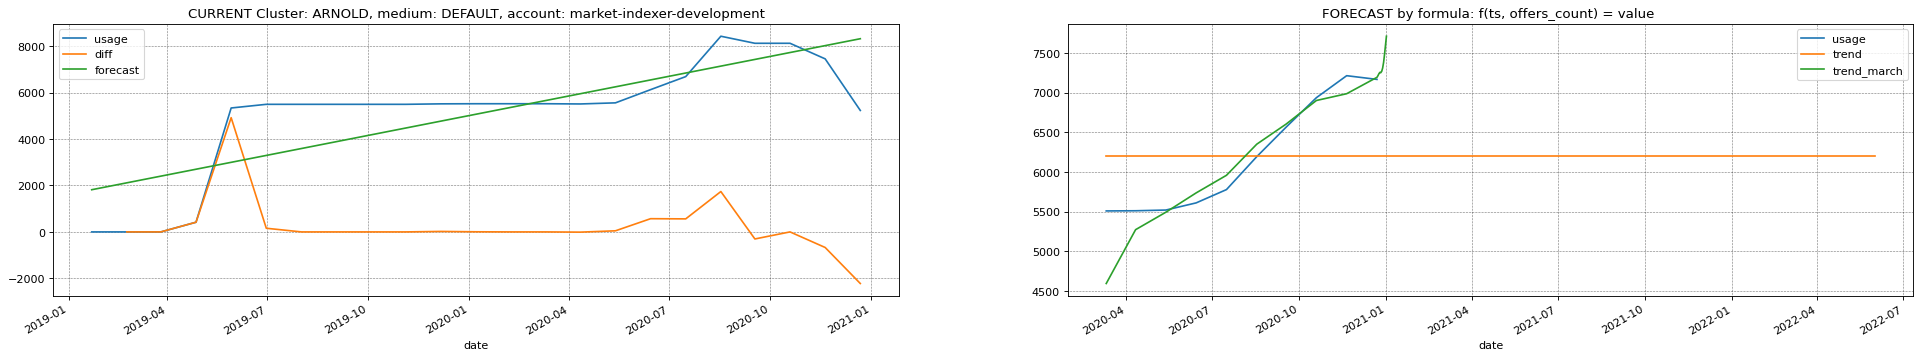

Correlations: {<Formula.F_TS_OFFERS_eq_VALUE: 'f(ts, offers_count) = value'>: 0.8795469220788285}


/Users/strkate/.conda/envs/capacity/lib/python3.8/site-packages/pandas/core/frame.py:1485: FutureWarning: Using short name for 'orient' is deprecated. Only the options: ('dict', list, 'series', 'split', 'records', 'index') will be used in a future version. Use one of the above to silence this warning.
  warnings.warn(
/Users/strkate/.conda/envs/capacity/lib/python3.8/site-packages/pandas/core/frame.py:1485: FutureWarning: Using short name for 'orient' is deprecated. Only the options: ('dict', list, 'series', 'split', 'records', 'index') will be used in a future version. Use one of the above to silence this warning.
  warnings.warn(


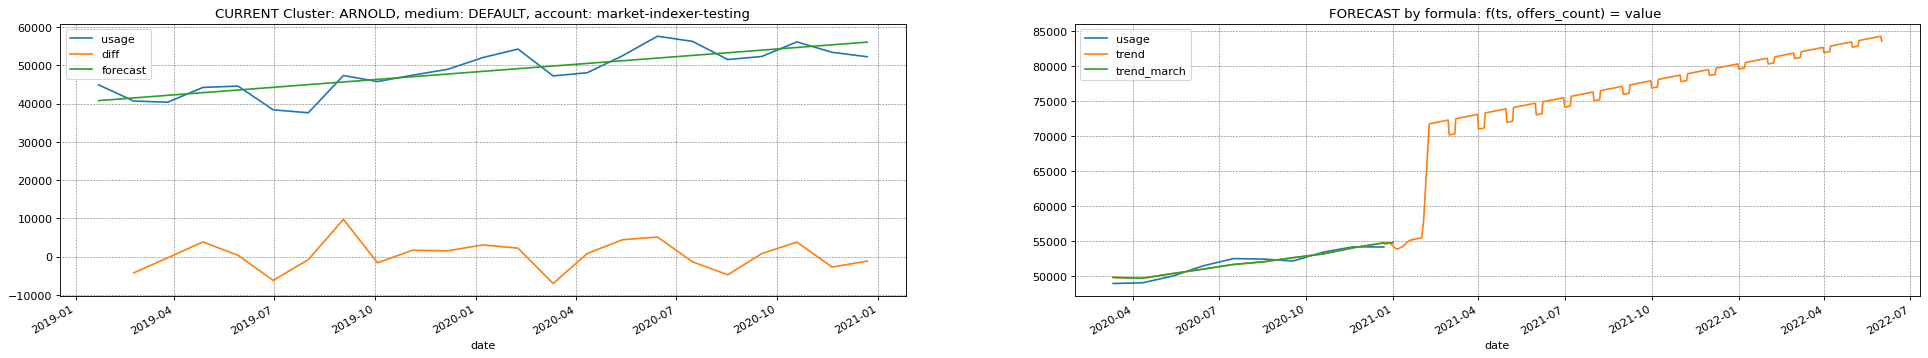

Correlations: {<Formula.F_TS_OFFERS_eq_VALUE: 'f(ts, offers_count) = value'>: 0.9174564171245521}


/Users/strkate/.conda/envs/capacity/lib/python3.8/site-packages/pandas/core/frame.py:1485: FutureWarning: Using short name for 'orient' is deprecated. Only the options: ('dict', list, 'series', 'split', 'records', 'index') will be used in a future version. Use one of the above to silence this warning.
  warnings.warn(
/Users/strkate/.conda/envs/capacity/lib/python3.8/site-packages/pandas/core/frame.py:1485: FutureWarning: Using short name for 'orient' is deprecated. Only the options: ('dict', list, 'series', 'split', 'records', 'index') will be used in a future version. Use one of the above to silence this warning.
  warnings.warn(


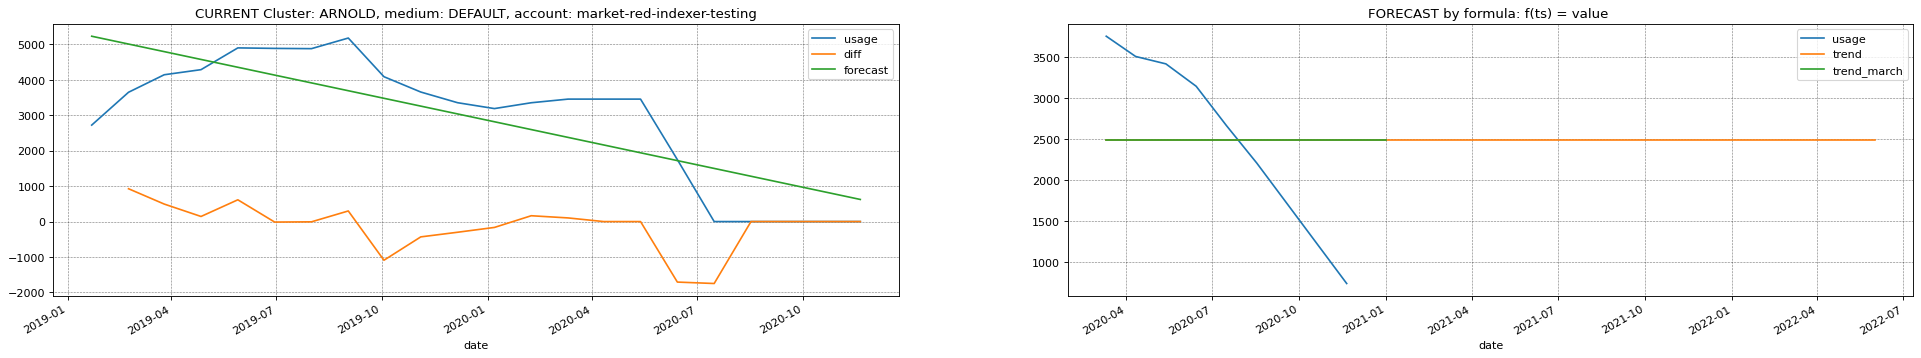

Correlations: {<Formula.F_TS_OFFERS_eq_DIFF: 'f(ts, offers_count) = diff'>: -0.7454044674505321,
 <Formula.F_TS_OFFERS_eq_VALUE: 'f(ts, offers_count) = value'>: -0.9067832328196286}


ARNOLD SSD usage: 10837 / 19958 Gb = 54.3 %


/Users/strkate/.conda/envs/capacity/lib/python3.8/site-packages/pandas/core/frame.py:1485: FutureWarning: Using short name for 'orient' is deprecated. Only the options: ('dict', list, 'series', 'split', 'records', 'index') will be used in a future version. Use one of the above to silence this warning.
  warnings.warn(
/Users/strkate/.conda/envs/capacity/lib/python3.8/site-packages/pandas/core/frame.py:1485: FutureWarning: Using short name for 'orient' is deprecated. Only the options: ('dict', list, 'series', 'split', 'records', 'index') will be used in a future version. Use one of the above to silence this warning.
  warnings.warn(


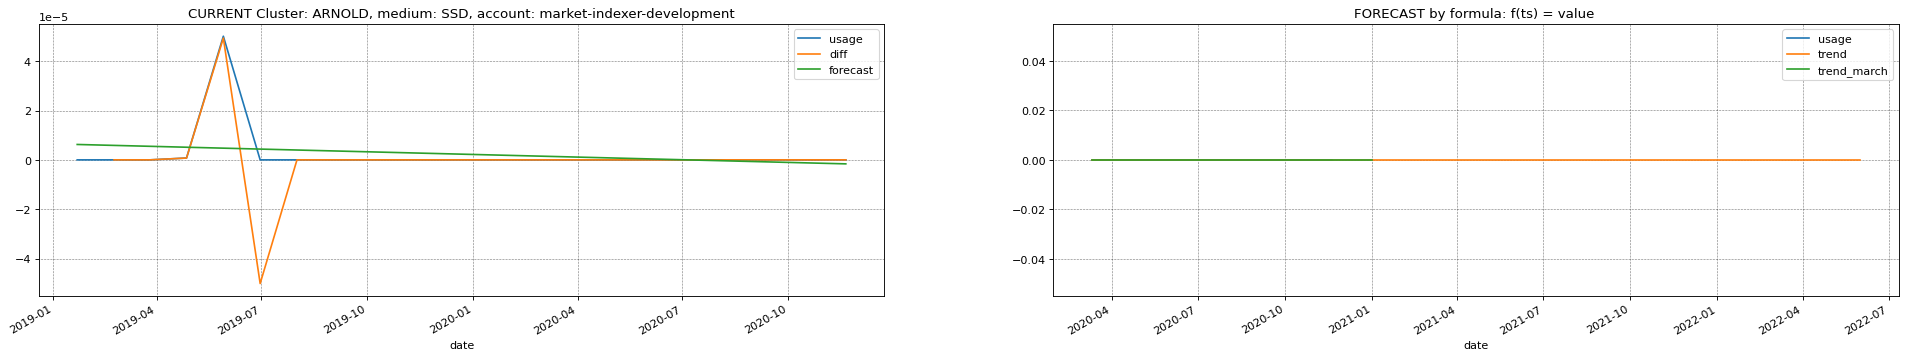

Correlations: {<Formula.F_TS_OFFERS_eq_DIFF: 'f(ts, offers_count) = diff'>: nan,
 <Formula.F_TS_OFFERS_eq_VALUE: 'f(ts, offers_count) = value'>: nan}


/Users/strkate/.conda/envs/capacity/lib/python3.8/site-packages/pandas/core/frame.py:1485: FutureWarning: Using short name for 'orient' is deprecated. Only the options: ('dict', list, 'series', 'split', 'records', 'index') will be used in a future version. Use one of the above to silence this warning.
  warnings.warn(
/Users/strkate/.conda/envs/capacity/lib/python3.8/site-packages/pandas/core/frame.py:1485: FutureWarning: Using short name for 'orient' is deprecated. Only the options: ('dict', list, 'series', 'split', 'records', 'index') will be used in a future version. Use one of the above to silence this warning.
  warnings.warn(


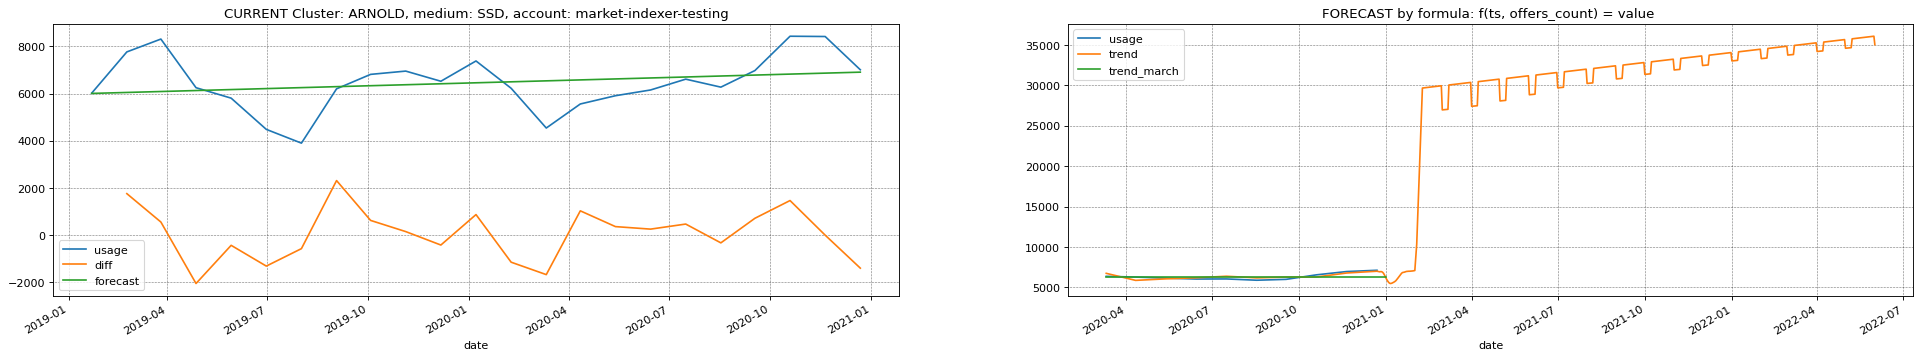

Correlations: {<Formula.F_TS_OFFERS_eq_VALUE: 'f(ts, offers_count) = value'>: 0.7821856961835841}


/Users/strkate/.conda/envs/capacity/lib/python3.8/site-packages/pandas/core/frame.py:1485: FutureWarning: Using short name for 'orient' is deprecated. Only the options: ('dict', list, 'series', 'split', 'records', 'index') will be used in a future version. Use one of the above to silence this warning.
  warnings.warn(
/Users/strkate/.conda/envs/capacity/lib/python3.8/site-packages/pandas/core/frame.py:1485: FutureWarning: Using short name for 'orient' is deprecated. Only the options: ('dict', list, 'series', 'split', 'records', 'index') will be used in a future version. Use one of the above to silence this warning.
  warnings.warn(


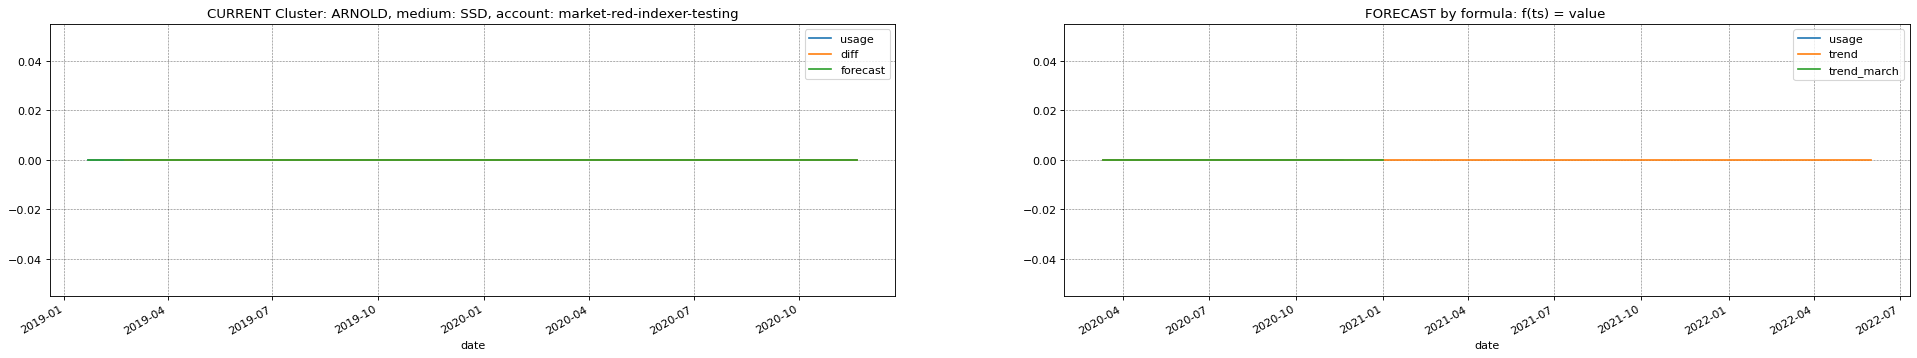

Correlations: {<Formula.F_TS_OFFERS_eq_DIFF: 'f(ts, offers_count) = diff'>: nan,
 <Formula.F_TS_OFFERS_eq_VALUE: 'f(ts, offers_count) = value'>: nan}


SENECA_SAS DEFAULT usage: 14 / 1024 Gb = 1.37 %


/Users/strkate/.conda/envs/capacity/lib/python3.8/site-packages/pandas/core/frame.py:1485: FutureWarning: Using short name for 'orient' is deprecated. Only the options: ('dict', list, 'series', 'split', 'records', 'index') will be used in a future version. Use one of the above to silence this warning.
  warnings.warn(
/Users/strkate/.conda/envs/capacity/lib/python3.8/site-packages/pandas/core/frame.py:1485: FutureWarning: Using short name for 'orient' is deprecated. Only the options: ('dict', list, 'series', 'split', 'records', 'index') will be used in a future version. Use one of the above to silence this warning.
  warnings.warn(


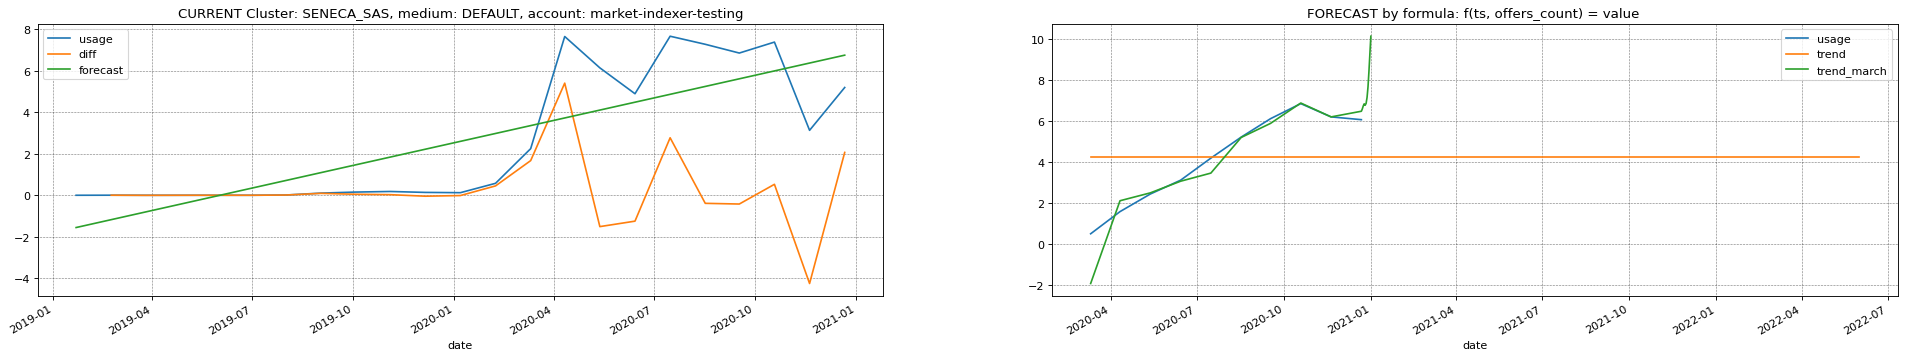

Correlations: {<Formula.F_TS_OFFERS_eq_VALUE: 'f(ts, offers_count) = value'>: 0.7743922110007859}


SENECA_SAS SSD usage: 127 / 1174 Gb = 10.82 %


/Users/strkate/.conda/envs/capacity/lib/python3.8/site-packages/pandas/core/frame.py:1485: FutureWarning: Using short name for 'orient' is deprecated. Only the options: ('dict', list, 'series', 'split', 'records', 'index') will be used in a future version. Use one of the above to silence this warning.
  warnings.warn(
/Users/strkate/.conda/envs/capacity/lib/python3.8/site-packages/pandas/core/frame.py:1485: FutureWarning: Using short name for 'orient' is deprecated. Only the options: ('dict', list, 'series', 'split', 'records', 'index') will be used in a future version. Use one of the above to silence this warning.
  warnings.warn(


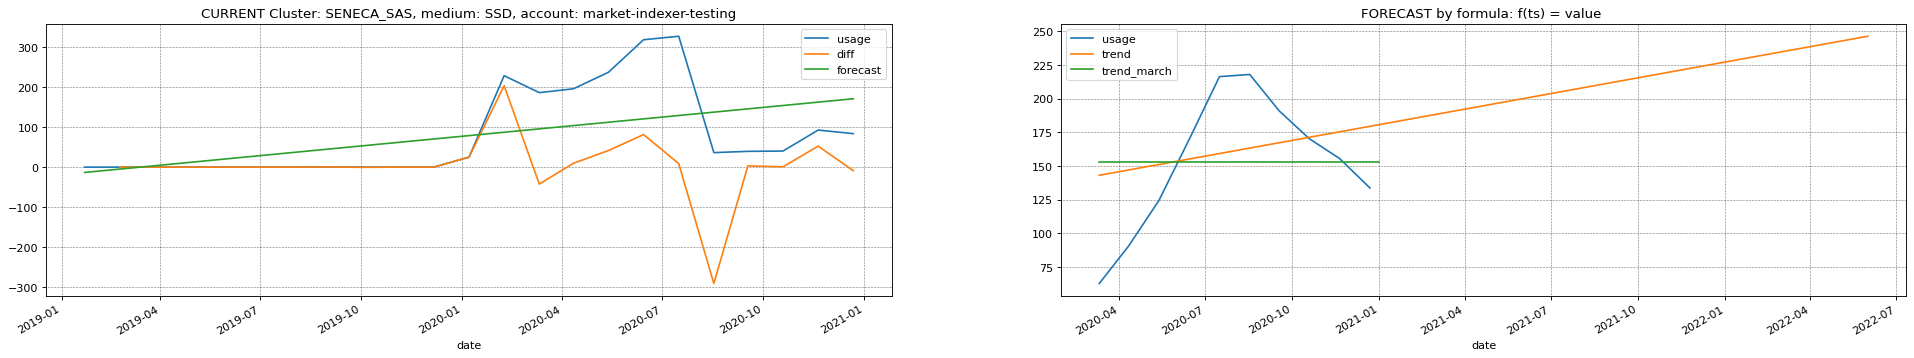

Correlations: {<Formula.F_TS_OFFERS_eq_DIFF: 'f(ts, offers_count) = diff'>: -0.6354797443878898,
 <Formula.F_TS_OFFERS_eq_VALUE: 'f(ts, offers_count) = value'>: 0.1565928550130057}


SENECA_VLA DEFAULT usage: 14 / 1024 Gb = 1.37 %


/Users/strkate/.conda/envs/capacity/lib/python3.8/site-packages/pandas/core/frame.py:1485: FutureWarning: Using short name for 'orient' is deprecated. Only the options: ('dict', list, 'series', 'split', 'records', 'index') will be used in a future version. Use one of the above to silence this warning.
  warnings.warn(
/Users/strkate/.conda/envs/capacity/lib/python3.8/site-packages/pandas/core/frame.py:1485: FutureWarning: Using short name for 'orient' is deprecated. Only the options: ('dict', list, 'series', 'split', 'records', 'index') will be used in a future version. Use one of the above to silence this warning.
  warnings.warn(


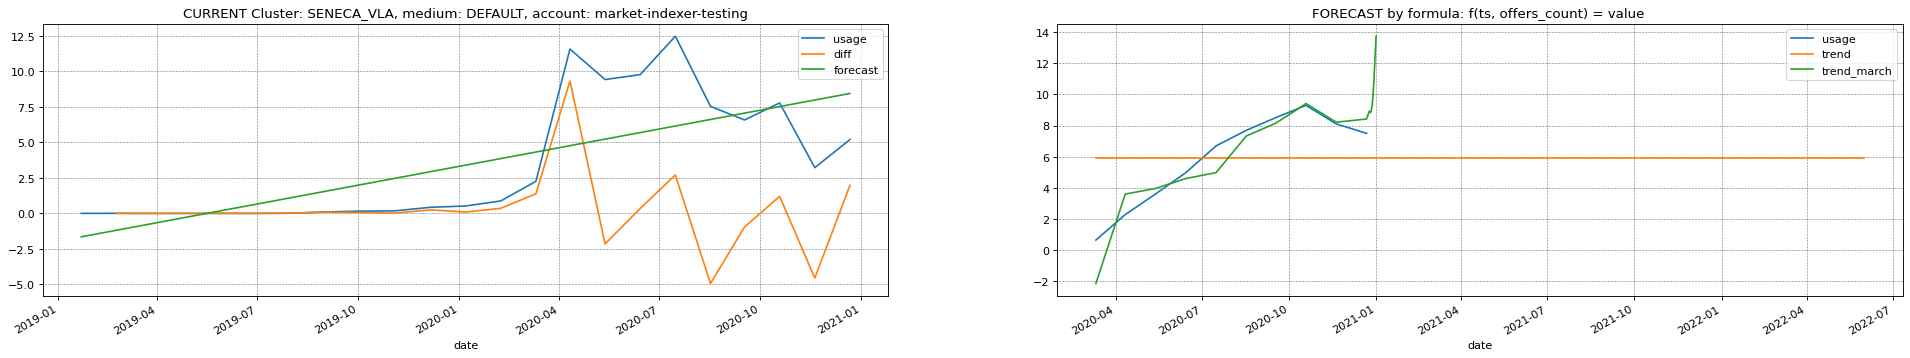

Correlations: {<Formula.F_TS_OFFERS_eq_VALUE: 'f(ts, offers_count) = value'>: 0.6882015208769724}


SENECA_VLA SSD usage: 116 / 1174 Gb = 9.88 %


/Users/strkate/.conda/envs/capacity/lib/python3.8/site-packages/pandas/core/frame.py:1485: FutureWarning: Using short name for 'orient' is deprecated. Only the options: ('dict', list, 'series', 'split', 'records', 'index') will be used in a future version. Use one of the above to silence this warning.
  warnings.warn(
/Users/strkate/.conda/envs/capacity/lib/python3.8/site-packages/pandas/core/frame.py:1485: FutureWarning: Using short name for 'orient' is deprecated. Only the options: ('dict', list, 'series', 'split', 'records', 'index') will be used in a future version. Use one of the above to silence this warning.
  warnings.warn(


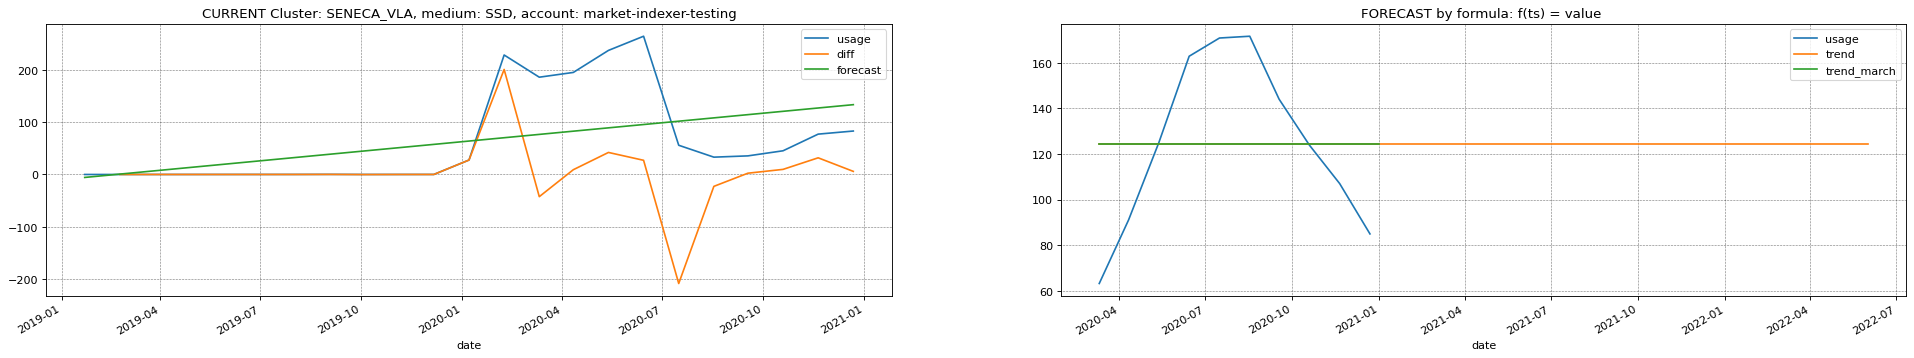

Correlations: {<Formula.F_TS_OFFERS_eq_DIFF: 'f(ts, offers_count) = diff'>: -0.7430974970615429,
 <Formula.F_TS_OFFERS_eq_VALUE: 'f(ts, offers_count) = value'>: -0.3122527393828911}


In [12]:
disk_forecast = get_disk_forecast(predictor=predictor,
                                  formula=formula,
                                  formula_strategy=formula_strategy,
                                  features=features,
                                  window=Window(),
                                  decreasing_base_function=decreasing_base_function,
                                  decreasing_reserve=decreasing_reserve,
                                  cluster_accounts=cluster_accounts,
                                  date_start=date_start,
                                  date_end=date_end,
                                  verbose=verbose,
                                  grid=grid,
                                  forecast_end_date=forecast_date
                                 )

In [13]:
disk_forecast_df = pd.DataFrame(disk_forecast).set_index(['cluster', 'account', 'medium'])
disk_forecast_df

predicted_usage_gb      reason  \
cluster    account                    medium                                    
HAHN       market-indexer-development DEFAULT             2830253      OFFERS   
           market-indexer-testing     DEFAULT               33498  CUMULATIVE   
           market-indexer-development SSD                    2301  CUMULATIVE   
           market-indexer-testing     SSD                    4179  CUMULATIVE   
ARNOLD     market-indexer-development DEFAULT                6201      OFFERS   
           market-indexer-testing     DEFAULT               79023      OFFERS   
           market-red-indexer-testing DEFAULT                2489  CUMULATIVE   
           market-indexer-development SSD                       0  CUMULATIVE   
           market-indexer-testing     SSD                   28734      OFFERS   
           market-red-indexer-testing SSD                       0  CUMULATIVE   
SENECA_SAS market-indexer-testing     DEFAULT                   5      OFFERS   
                                      SSD                     247  CUMULATIVE   
SENECA_VLA market-indexer-testing     DEFAULT                   6      OFFERS   
                                      SSD                     125  CUMULATIVE   

                                               usage_gb  quota_gb  \
cluster    account                    medium                        
HAHN       market-indexer-development DEFAULT      3051     10240   
           market-indexer-testing     DEFAULT     23732     30720   
           market-indexer-development SSD          2301         0   
           market-indexer-testing     SSD           263      9718   
ARNOLD     market-indexer-development DEFAULT      5231     10240   
           market-indexer-testing     DEFAULT     52215     64512   
           market-red-indexer-testing DEFAULT         0      5735   
           market-indexer-development SSD             0         0   
           market-indexer-testing     SSD          7012     19958   
           market-red-indexer-testing SSD             0      3687   
SENECA_SAS market-indexer-testing     DEFAULT         6      1024   
                                      SSD            84      1174   
SENECA_VLA market-indexer-testing     DEFAULT         6      1024   
                                      SSD            84      1174   

                                                                                           trend  
cluster    account                    medium                                                      
HAHN       market-indexer-development DEFAULT  {"trend":{"1583884800000":null,"1586563200000"...  
           market-indexer-testing     DEFAULT  {"trend":{"1583884800000":33497.6183829611,"15...  
           market-indexer-development SSD      {"trend":{"1583884800000":2300.3126670225,"158...  
           market-indexer-testing     SSD      {"trend":{"1583884800000":4178.678096195,"1586...  
ARNOLD     market-indexer-development DEFAULT  {"trend":{"1583884800000":6200.3908875586,"158...  
           market-indexer-testing     DEFAULT  {"trend":{"1583884800000":49834.5006069616,"15...  
           market-red-indexer-testing DEFAULT  {"trend":{"1583884800000":2488.9314202143,"158...  
           market-indexer-development SSD      {"trend":{"1583884800000":0.0,"1586563200000":...  
           market-indexer-testing     SSD      {"trend":{"1583884800000":6746.9131642641,"158...  
           market-red-indexer-testing SSD      {"trend":{"1583884800000":0.0,"1586563200000":...  
SENECA_SAS market-indexer-testing     DEFAULT  {"trend":{"1583884800000":4.2237890348,"158656...  
                                      SSD      {"trend":{"1583884800000":143.0955746399,"1586...  
SENECA_VLA market-indexer-testing     DEFAULT  {"trend":{"1583884800000":5.9326837552,"158656...  
                                      SSD      {"trend":{"1583884800000":124.4661956035,"1586...

In [14]:
from market.sre.tools.capacity.preorder.v2020apr.additional.RTC.src.forecast.ForecastDAO import ForecastDAO, ForecastTable

forecast_dto=[]
for key, value in disk_forecast_df.iterrows():
    cluster, account, medium = key
    predicted_usage_gb = value.predicted_usage_gb
    quota_gb = value.quota_gb
    usage_gb = value.usage_gb
    reason = value.reason
    
    if medium == 'DEFAULT':
        disk_quota=YtOrderRequestFileItemDiskQuota(
            accounts=[account],
            hdd_quota_gb=quota_gb,
            hdd_usage_gb=usage_gb,
            predicted_hdd_usage_gb=predicted_usage_gb if 'SENECA' in cluster else int(disk_forecast_df.query(f"account == '{account}' & medium == '{medium}'").max()['predicted_usage_gb']),
        )
    elif medium == 'SSD':
        disk_quota=YtOrderRequestFileItemDiskQuota(
            accounts=[account],
            ssd_quota_gb=quota_gb,
            ssd_usage_gb=usage_gb,
            # https://st.yandex-team.ru/MARKETPREORDER-6
            predicted_ssd_usage_gb=predicted_usage_gb if 'SENECA' in cluster else int(disk_forecast_df.query(f"account == '{account}' & medium == '{medium}'").max()['predicted_usage_gb']),
#             predicted_ssd_usage_gb=predicted_usage_gb
        )
    else:
        raise
    
    resource_info = whois.get_info(Cloud.YT, clean_YT_account(account))
    department_info = DepartmentInfo.from_file(capacity_path / preorder_key / 'input_data/orders', resource_info['department'])
    file_item = YTOrderRequestFileItem(cluster=Cluster.from_str(cluster), 
                                       dc=Cluster.from_str(cluster).get_dc(), 
                                       disk_quota=disk_quota)
    
    result_dir_path = capacity_path / preorder_key / result_dir / (f"{resource_info['department']}/{Cloud.YT}")
    Path(result_dir_path).mkdir(parents=True, exist_ok=True)
    file_path = result_dir_path / (f"disk-{cluster}-{account}-{medium}.yaml")

    YTOrderRequestFile(
        department=resource_info['department'],
        cloud=Cloud.YT,
        platform=resource_info['platform'],
        ticket='',
        contacts={},
        deadline=Deadline.EVENLY,
        items=[file_item],
        file_path=str(target_dir / f'{service_file_name}_disk.yaml'),
        reason=Reason.from_str(reason),
        generated=True,
        source_meta={'kpi': kpi_key}).dump_to_file()
    forecast_disk=ForecastDAO(
            metric = str(medium),
            environment = str(account.split('-')[-1]),
            kpi = kpi_key,
            cloud = "YT",
            abc_service = department_info.abc_slug,
            entity = str(account),
            forecast_start_date = forecast_start_date,
            forecast_end_date = forecast_end_date,
            history_start_date = history_start_date,
            history_end_date = history_end_date,
            result_df = value.trend,
            result_by_date = predicted_usage_gb if not np.isnan(predicted_usage_gb) else 0,
            preorder_id = 'feb21',
            source_meta = {'cluster': cluster}
        )
    forecast_dto.append(forecast_disk)
ForecastDAO.save_forecast(client = ForecastDAO.get_client(), forecasts=forecast_dto, table=ForecastTable('yt_accounts').get_forecast_table_path())

In [15]:
df = disk_forecast_df.rename(columns={
                   'quota': 'current_allocation', 
                   'predicted_usage_gb': 'future_allocation',
                    'reason': 'correlation'}).reset_index()
df['service'] = df['cluster'] + '_' + df['account'] + '_' + df['medium']
df.to_json(target_dir / f'{service_file_name}_disk.json')

### CPU

In [16]:
label = 'indexer'

_hahn_pools_list = [pool for pool in hahn_pools_list if label in pool and env in pool]
_arnold_pools_list = [pool for pool in arnold_pools_list if label in pool and env in pool]

cluster_pools = {
#     Cluster.HAHN: _hahn_pools_list,
    Cluster.HAHN: ['market-testing-indexer'],
#     Cluster.ARNOLD: _arnold_pools_list
    Cluster.ARNOLD: ['market-testing-indexer'],
}

print(cluster_pools)

{<Cluster.HAHN: 'hahn'>: ['market-testing-indexer'], <Cluster.ARNOLD: 'arnold'>: ['market-testing-indexer']}


/Users/strkate/.conda/envs/capacity/lib/python3.8/site-packages/pandas/core/frame.py:1485: FutureWarning: Using short name for 'orient' is deprecated. Only the options: ('dict', list, 'series', 'split', 'records', 'index') will be used in a future version. Use one of the above to silence this warning.
  warnings.warn(


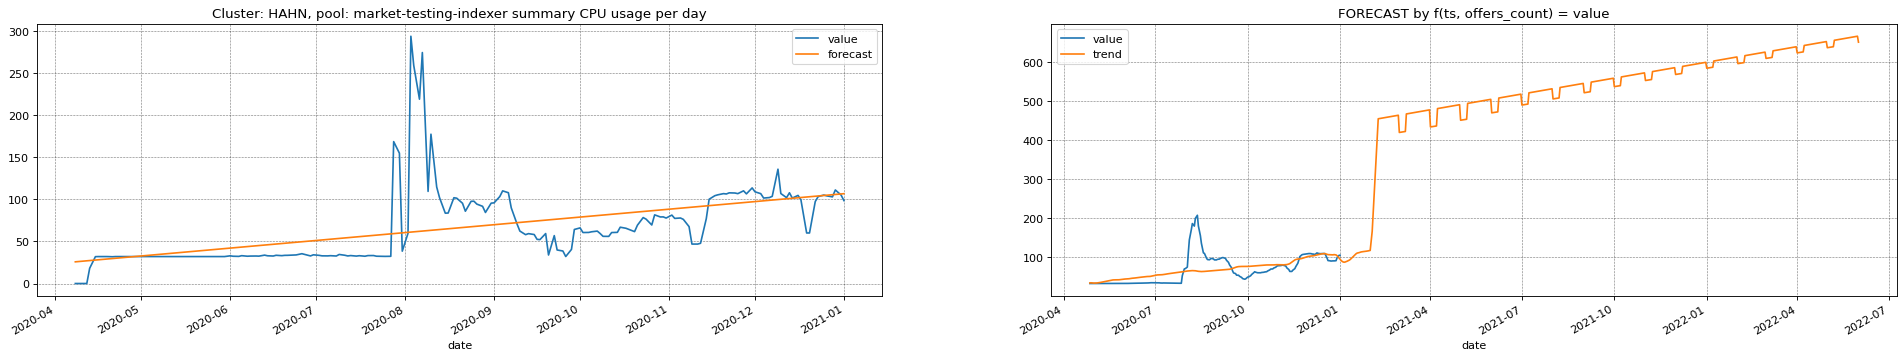

Correlations: {<Formula.F_TS_OFFERS_eq_VALUE: 'f(ts, offers_count) = value'>: 0.502089572723581}
Базовый прогноз: 557.0232450493063 ядер


/Users/strkate/.conda/envs/capacity/lib/python3.8/site-packages/pandas/core/frame.py:1485: FutureWarning: Using short name for 'orient' is deprecated. Only the options: ('dict', list, 'series', 'split', 'records', 'index') will be used in a future version. Use one of the above to silence this warning.
  warnings.warn(


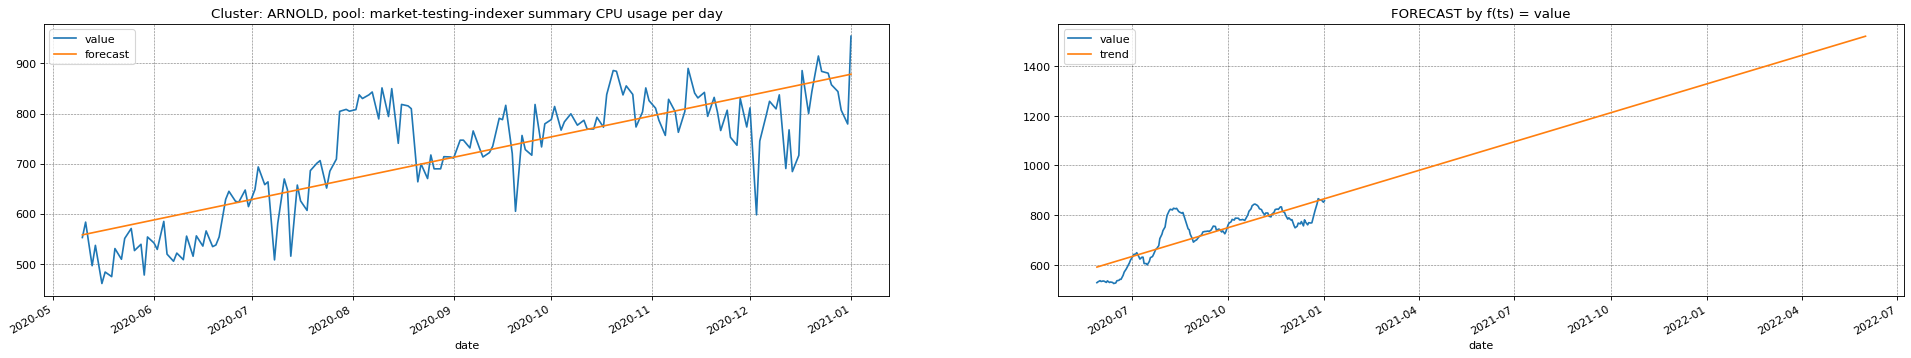

Correlations: {<Formula.F_TS_OFFERS_eq_DIFF: 'f(ts, offers_count) = diff'>: 0.03612027824722269,
 <Formula.F_TS_OFFERS_eq_VALUE: 'f(ts, offers_count) = value'>: 0.4649118585325638}
Базовый прогноз: 1519.4954127295132 ядер


In [17]:
cpu_forecast = get_cpu_forecast(predictor=predictor,
                                cluster_pools=cluster_pools,
                                formula=formula,
                                formula_strategy=formula_strategy,
                                features=features,
                                window=Window(),
                                decreasing_base_function=decreasing_base_function,
                                decreasing_reserve=decreasing_reserve,
                                consider_peaks=consider_peaks,
                                date_start=date_start,
                                date_end=date_end,
                                peaks_window_1=5,
                                peaks_window_2=60,
                                verbose=verbose,
                                grid=grid,
                                tail_depth=tail_depth,
                                quantile=quantile,
                                forecast_end_date=forecast_date)

In [18]:
if not cpu_forecast:
    cpu_forecast = pd.DataFrame.from_records([{'cluster':'HAHN', 'pool':'lalala', 'predicted_usage': 0, 'reason': 'CUMULATIVE', 'peak_coef':0,'usage':0,'quota':0}])
cpu_forecast_df = pd.DataFrame(cpu_forecast).set_index(['cluster', 'pool'])
cpu_forecast_df

,,predicted_usage,reason,peak_coef,usage,quota,trend
cluster,pool,,,,,,
HAHN,market-testing-indexer,558,OFFERS,1,106,600,{}
ARNOLD,market-testing-indexer,1520,CUMULATIVE,1,884,500,{}


In [19]:
forecast_dto = []
for key, value in cpu_forecast_df.iterrows():
    cluster, pool = key
    predicted_usage = value.predicted_usage
    quota = value.quota
    usage = value.usage
    peak_coef = value.peak_coef
    reason = value.reason
    
    cpu_quota=YtOrderRequestFileItemCpuQuota(
        pools=[pool],
        cpu_quota=quota,
        cpu_usage=usage,
        # https://st.yandex-team.ru/MARKETPREORDER-6
        predicted_cpu_usage=int(cpu_forecast_df.query(f"pool == '{pool}' & (cluster == 'HAHN' | cluster == 'ARNOLD')").max()['predicted_usage']),
#         predicted_cpu_usage=predicted_usage,
        cpu_peak_coef=peak_coef
    )
    
    resource_info = whois.get_info(Cloud.YT, pool)
    department_info = DepartmentInfo.from_file(capacity_path / preorder_key / 'input_data/orders', resource_info['department'])
    file_item = YTOrderRequestFileItem(cluster=Cluster.from_str(cluster), 
                                       dc=Cluster.from_str(cluster).get_dc(), 
                                       cpu_quota=cpu_quota)
    
    result_dir_path = capacity_path / preorder_key / result_dir / (f"{resource_info['department']}/{Cloud.YT}")
    Path(result_dir_path).mkdir(parents=True, exist_ok=True)
    file_path = result_dir_path / (f"pool-{cluster}-{pool}.yaml")
    
    YTOrderRequestFile(
        department=resource_info['department'],
        cloud=Cloud.YT,
        platform=resource_info['platform'],
        ticket='',
        contacts={},
        deadline=Deadline.EVENLY,
        items=[file_item],
        file_path=str(target_dir / f'{service_file_name}_cpu.yaml'),
        reason=Reason.from_str(reason),
        generated=True,
        source_meta={'kpi': kpi_key}).dump_to_file()
    forecast_cpu=ForecastDAO(
            metric = 'CPU',
            environment = str(account.split('-')[-1]),
            kpi = kpi_key,
            cloud = "YT",
            abc_service = department_info.abc_slug,
            entity = str(pool),
            forecast_start_date = forecast_start_date,
            forecast_end_date = forecast_end_date,
            history_start_date = history_start_date,
            history_end_date = history_end_date,
            result_df = value.trend,
            result_by_date = predicted_usage if not np.isnan(predicted_usage) else 0,
            preorder_id = 'feb21',
            source_meta = {'cluster': cluster}
        )
    forecast_dto.append(forecast_cpu)
ForecastDAO.save_forecast(client = ForecastDAO.get_client(), forecasts=forecast_dto, table=ForecastTable('yt_pools').get_forecast_table_path())

In [20]:
df = cpu_forecast_df.rename(columns={
                   'quota': 'current_allocation', 
                   'predicted_usage': 'future_allocation',
                    'reason': 'correlation'}).reset_index()
df['service'] = df['cluster'] + '_' + df['pool'] + '_cpu'
df.to_json(target_dir / f'{service_file_name}_cpu.json')